In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# Number of age groups used in the model
age_stratification_size=10
# Startdate of model
start_date = '2020-03-15'

In [3]:
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_date, update_data=False)

In [4]:
agg=None
age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
df = sciensano.get_public_spatial_vaccination_data(agg=agg, update=False)
df = df['INCIDENCE']

In [31]:
from functools import lru_cache

class make_N_vacc_function():
    """A time-dependent parameter function to return the vaccine incidence at each timestep of the simulation
       Includes an example of a "hypothetical" booster campaign
    """
    
    def __init__(self, df_incidences, agg=None, age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left'),
                 hypothetical_function=False):
        
        #####################
        ## Input variables ##
        #####################
        
        # Window length of exponential moving average to smooth vaccine incidence
        filter_length = 14
        # Parameters of hypothetical booster campaign
        weekly_doses = 7*30000
        vacc_order = list(range(len(age_classes)))[::-1]
        stop_idx = len(age_classes)
        refusal = 0.1*np.ones(len(age_classes))
        extend_weeks = 24        
        
        ############################################################
        ## Check if Sciensano changed the definition of the doses ##
        ############################################################
        
        df = df_incidences
        if not (df.index.get_level_values('dose').unique() == ['A', 'B', 'C', 'E']).all():
            # This code was built at a point in time when the following doses were in the raw dataset provided by Sciensano:
            # A: 0 --> P, B: P --> F, C: 0 --> F, E: F --> B
            # If you get this error it means Sciensano has changed the definition of these doses
            raise ValueError("The names of the 'doses' in the vaccination dataset have been changed from those the code was designed for ({0})".format(df.index.get_level_values('dose').unique().values))
        
        ####################################
        ## Step 1: Perform age conversion ##
        ####################################
        
        # Only perform age conversion if necessary
        if len(age_classes) != len(df.index.get_level_values('age').unique()):
            df = self.age_conversion(df, age_classes, agg)
        elif (age_classes != df.index.get_level_values('age').unique()).any():
            df = self.age_conversion(df, age_classes, agg)
        
        ###############################################
        ## Step 2: Hypothetical vaccination campaign ##
        ###############################################
        
        if hypothetical_function:
            # REMARK: It would be more elegant to have the user supply a "hypothetical function" together with
            # a dictionary of arguments to the __init__ function.
            # However, since I don't really need hypothetical functions at the moment (2022-05), I'm going to park this
            df = self.append_booster_campaign(df, extend_weeks, weekly_doses, vacc_order, stop_idx, refusal)
        
        #####################################################################
        ## Step 3: Convert weekly to daily incidences and smooth using EMA ##
        #####################################################################

        df = self.smooth_incidences(df, filter_length, agg)
        
        ##################################################
        ## Step 4: Assign relevant (meta)data to object ##
        ##################################################
        
        # Dataframe 
        self.df = df
        # Number of spatial patches
        try:
            self.G = len(self.df.index.get_level_values('NIS').unique().values)
        except:
            pass
        # Aggregation    
        self.agg = agg
        # Number of age groups
        self.N = len(age_classes)
        # Number of vaccine doses
        self.D = len(self.df.index.get_level_values('dose').unique().values)
        
        return None
        
    @lru_cache()
    def get_data(self,t):
        """
        Function to extract the vaccination incidence at date 't' from the pd.Dataframe of incidences and format it into the right size
        """
        if self.agg:
            try:
                return np.array(self.df.loc[t,:,:,:].values).reshape( (self.G, self.N, self.D) )
            except:
                return np.zeros([self.G, self.N, self.D])
        else:
            try:
                return np.array(self.df.loc[t,:,:].values).reshape( (self.N, self.D) )
            except:
                return np.zeros([self.N, self.D])
    
    def __call__(self, t, states, param):
        """
        Time-dependent parameter function compatible wrapper for cached function `get_data`
        Returns the vaccination incidence at time "t"
        
        Input
        -----
        
        t : pd.Timestamp
            Current date in simulation
        
        Returns
        -------
        
        N_vacc : np.array
            Number of individuals to be vaccinated at simulation time "t" per [age, (space), dose]
        """

        return self.get_data(t)
    
    ######################
    ## Helper functions ##
    ######################
    
    @staticmethod
    def smooth_incidences(df, filter_length, agg):
        """
        A function to convert the vaccine incidences dataframe from weekly to daily data and smooth the incidences with an exponential moving average
        
        Inputs
        ------
        df: pd.Series
            Pandas series containing the weekly vaccination incidences, indexed using a pd.Multiindex
            Obtained using the function `covid19model.data.sciensano.get_public_spatial_vaccination_data()`
            Must contain 'date', 'age' and 'dose' as indices for the national model
            Must contain 'date', 'NIS', 'age', 'dose' as indices for the spatial model
        
        filter_length: int
            Window length of the exponential moving average
            
        agg: str or None
            Spatial aggregation level. `None` for the national model, 'prov' for the provincial level, 'arr' for the arrondissement level
        
        Output
        ------
        
        df: pd.Series
            Pandas series containing smoothed daily vaccination incidences, indexed using the same pd.Multiindex as the input
        
        """
        
        # Start- and enddate
        df_start = pd.Timestamp(df.index.get_level_values('date').min())
        df_end = pd.Timestamp(df.index.get_level_values('date').max())
    
        # Make a dataframe with the desired format
        iterables=[]
        for index_name in df.index.names:
            if index_name != 'date':
                iterables += [df.index.get_level_values(index_name).unique()]
            else:
                iterables += [pd.date_range(start=df_start, end=df_end, freq='D'),]
        index = pd.MultiIndex.from_product(iterables, names=df.index.names)
        df_new = pd.Series(index=index, name = df.name, dtype=float)

        # Loop over (NIS),age,dose
        for age in df.index.get_level_values('age').unique():
            for dose in df.index.get_level_values('dose').unique():
                if agg:
                    for NIS in df.index.get_level_values('NIS').unique():
                         # Convert weekly to daily data
                        daily_data = df.loc[slice(None), NIS, age, dose].resample('D').bfill().apply(lambda x : x/7)
                        # Apply an exponential moving average
                        daily_data_EMA = daily_data.ewm(span=filter_length, adjust=False).mean()
                        # Assign to new dataframe
                        df_new.loc[slice(None), NIS, age, dose] = daily_data_EMA.values
                else:
                    # Convert weekly to daily data
                    daily_data = df.loc[slice(None), age, dose].resample('D').bfill().apply(lambda x : x/7)
                    # Apply an exponential moving average
                    daily_data_EMA = daily_data.ewm(span=filter_length, adjust=False).mean()
                    # Assign to new dataframe
                    df_new.loc[slice(None), age, dose] = daily_data_EMA.values
                    
        return df_new
        
    @staticmethod
    def age_conversion(df, desired_age_classes, agg):
        """
        A function to convert a dataframe of vaccine incidences to another set of age groups `desired_age_classes` using demographic weighing
        
        Inputs
        ------
        
         df: pd.Series
            Pandas series containing the vaccination incidences, indexed using a pd.Multiindex
            Obtained using the function `covid19model.data.sciensano.get_public_spatial_vaccination_data()`
            Must contain 'date', 'age' and 'dose' as indices for the national model
            Must contain 'date', 'NIS', 'age', 'dose' as indices for the spatial model  
            
        desired_age_classes: pd.IntervalIndex
            Age groups you want the vaccination incidence to be formatted in
            Example: pd.IntervalIndex.from_tuples([(0,20),(20,60),(60,120)], closed='left')
        
        agg: str or None
            Spatial aggregation level. `None` for the national model, 'prov' for the provincial level, 'arr' for the arrondissement level
           
        Returns
        -------
        
        df_new: pd.Series
            Same pd.Series containing the vaccination incidences, but uses the age groups in `desired_age_classes`
        
        """
        
        
        from covid19model.data.utils import convert_age_stratified_quantity
        
        # Define a new dataframe with the desired age groups
        iterables=[]
        for index_name in df.index.names:
            if index_name != 'age':
                iterables += [df.index.get_level_values(index_name).unique()]
            else:
                iterables += [desired_age_classes]
        index = pd.MultiIndex.from_product(iterables, names=df.index.names)
        df_new = pd.Series(index=index, dtype=float)
        
        # Loop to the dataseries level and perform demographic aggregation
        if agg:
            for date in df.index.get_level_values('date').unique():
                for NIS in df.index.get_level_values('NIS').unique():
                    for dose in df.index.get_level_values('dose').unique():
                        data = df.loc[date, NIS, slice(None), dose].reset_index().set_index('age')
                        df_new.loc[date, NIS, slice(None), dose] = convert_age_stratified_quantity(data, desired_age_classes, agg=agg, NIS=NIS).values
        else:
            for date in df.index.get_level_values('date').unique():
                for dose in df.index.get_level_values('dose').unique():
                    df_new.loc[date, slice(None), dose] = convert_age_stratified_quantity(data, desired_age_classes).values

        return df_new
    
    @staticmethod
    def append_booster_campaign(df, extend_weeks, weekly_doses, vacc_order, stop_idx, refusal):
        """
        A function that appends `extend_weeks` of a hypothetical booster campaign to the dataframe containing the weekly vaccination incidences `df`
        Does not work for the spatial model!
        
        Inputs
        ------
        
        df: pd.Series
            Pandas series containing the weekly vaccination incidences, indexed using a pd.Multiindex
            Obtained using the function `covid19model.data.sciensano.get_public_spatial_vaccination_data()`
            Must contain 'date', 'age' and 'dose' as indices for the national model
        
        extend_weeks: int
            Number of weeks the incidences dataframe should be extended
            
        weekly_doses: int/float
            Number of weekly doses to be administered
        
        vacc_order: list/np.array
            A list containing the age-specific order in which the vaccines should be administered
            Must be the same length as the number of age groups in the model
            f.e. [9 8 .. 1 0] means elderly are prioritized
            
        stop_idx: int
            Number of age groups the algorithm should loop over
            f.e. len(age_classes) means all age groups are vaccine eligible
            f.e. len(age_classes)-1 means the algorithm stops at the last index of vacc_order
        
        refusal: list/np.array
            Vaccine refusal rate in age group i 
            Must be the same length as the number of age groups in the model
        
        Outputs
        -------
        
        df: pd.Series
            Pandas series containing the weekly vaccination indices, extended with a hypothetical booster campaign
            Multiindex from the input series is retained
        """
        
        
        # Index of desired output dose
        dose_idx = 3 # Administering boosters
        
        # Start from the supplied data
        df_out = df  
        
        # Metadata
        N = len(df.index.get_level_values('age').unique())
        D = len(df.index.get_level_values('dose').unique())
        
        # Generate desired daterange
        df_end = pd.Timestamp(df.index.get_level_values('date').max())
        date_range = pd.date_range(start=df_end+pd.Timedelta(days=7), end=df_end+pd.Timedelta(days=7*extend_weeks), freq='W-MON')
        
        # Compute the number of fully vaccinated individuals in every age group
        cumulative_F=[]
        for age_class in df.index.get_level_values('age').unique():
            cumulative_F.append((df.loc[slice(None), age_class, 'B'] + df.loc[slice(None), age_class, 'C']).cumsum().iloc[-1])
        
        # Loop over dates
        weekly_doses0 = weekly_doses
        for date in date_range:
            # Reset the weekly doses
            weekly_doses = weekly_doses0
            # Compute the cumulative number of boosted individuals
            cumulative_B=[]
            for age_class in df_out.index.get_level_values('age').unique():
                cumulative_B.append(df_out.loc[slice(None), age_class, 'E'].cumsum().iloc[-1])
            # Initialize N_vacc
            N_vacc = np.zeros([N,D])
            # Booster vaccination loop
            idx = 0
            while weekly_doses > 0:
                if idx == stop_idx:
                    weekly_doses= 0
                else:
                    doses_needed = (1-refusal[vacc_order[idx]])*cumulative_F[vacc_order[idx]] - cumulative_B[vacc_order[idx]]
                    if doses_needed > weekly_doses:
                        N_vacc[vacc_order[idx],dose_idx] = weekly_doses
                        weekly_doses = 0
                    elif doses_needed >= 0:
                        N_vacc[vacc_order[idx],dose_idx] = doses_needed
                        weekly_doses -= doses_needed
                    else:
                        N_vacc[vacc_order[idx],dose_idx] = 0
                    idx+=1
                    
            # Generate series on date with same multiindex as output
            iterables=[]
            for index_name in df.index.names:
                if index_name != 'date':
                    iterables += [df.index.get_level_values(index_name).unique()]
                else:
                    iterables += [[date],]
            index = pd.MultiIndex.from_product(iterables, names=df.index.names)
            df_new = pd.Series(index=index, name=df.name, dtype=float)
            # Put the result in
            df_new.loc[date, slice(None), slice(None)] = N_vacc.flatten()
            # Concatenate
            df_out = pd.concat([df_out, df_new])
        
        return df_out

In [32]:
# Slice dataset to a moment before the booster campaign
start_booster = '2021-10-04'
df_incidences = df.loc[slice('2020-12-28',start_booster), slice(None), slice(None)]
# Initialize TDPF
output = make_N_vacc_function(agg=agg, df_incidences=df_incidences, hypothetical_function=True)

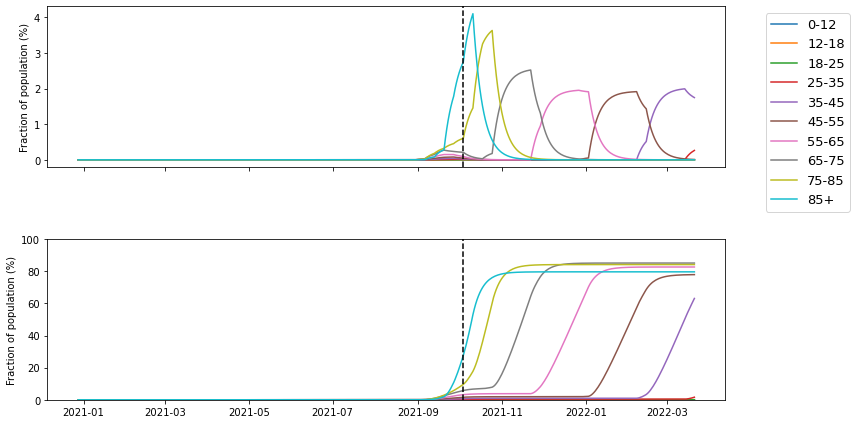

In [33]:
from covid19model.data.model_parameters import construct_initN
N = construct_initN(age_classes, None).values
data = output.df
dose='E'

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,6), sharex=True)

for idx, age_class in enumerate(age_classes):
    ax[0].plot(data.loc[slice(None),age_class,dose]/N[idx]*100)
    ax[1].plot(data.loc[slice(None),age_class,dose].cumsum()/N[idx]*100)

ax[0].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')
ax[1].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')

ax[0].set_ylabel('Fraction of population (%)')
ax[1].set_ylabel('Fraction of population (%)')

ax[1].set_ylim([0,100])


legend_text=['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']
ax[0].legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.tight_layout()
plt.savefig('hypothetical_booster_campaign_refusal10_30000.png', dpi=400)
plt.show()
plt.close()